#Description of the American Sign Language MNIST (Sbzrgn-Version)
https://www.kaggle.com/datasets/datamunge/sign-language-mnist

##### American Sign Language (ASL) is a complete, natural language that has the same linguistic properties as spoken languages, with grammar that differs from English. ASL is expressed by movements of the hands and face. It is the primary language of many North Americans who are deaf and hard of hearing, and is used by many hearing people as well. The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. To create new data, an image pipeline was used based on ImageMagick and included cropping to hands-only, gray-scaling, resizing, and then creating at least 50+ variations to enlarge the quantity.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

###Loading the ASL (American Sign Language) dataset
Note: You can download them from [Here](https://colab.research.google.com/drive/1v0ps8waU3IDm0YtzdJAhAgUUH19jyMe5#scrollTo=CP_zPL4Wr_lP&line=2&uniqifier=1)

In [34]:
train_df = pd.read_csv("sign_mnist_train.csv", sep=',', low_memory=False)
test_df = pd.read_csv("sign_mnist_test.csv", sep=',', on_bad_lines='skip', low_memory=False)
test = pd.read_csv("sign_mnist_test.csv")
y = test['label']

In [35]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


###Data Visualization and Preprocessing

<Axes: xlabel='label', ylabel='count'>

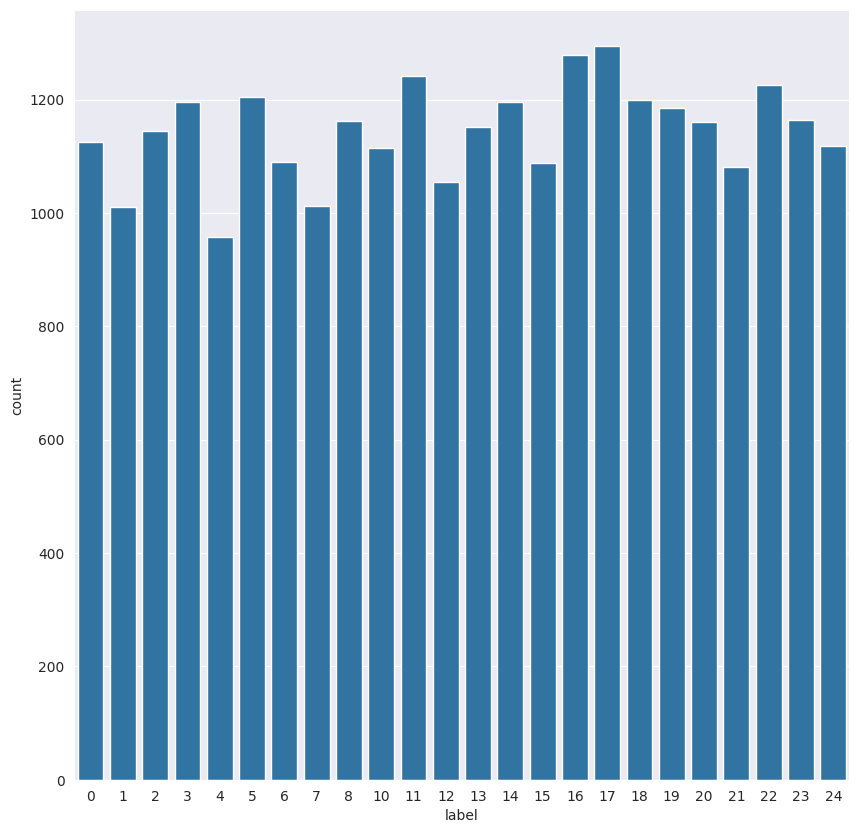

In [36]:
plt.figure(figsize = (10, 10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df, x = 'label')

In [37]:
y_train = train_df['label']
y_test = test_df['label']

del train_df['label']
del test_df['label']

In [38]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [39]:
x_train = train_df.values
x_test = test_df.values

### Normalize the data

In [40]:
x_train = x_train / 255
x_test = x_test / 255

### Reshaping the data from 1-D to 3-D as required through input by CNN's

In [41]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

###Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [42]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees
Randomly Zoom by 10% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify.

Once our model is ready, we fit the training dataset .

### Training The Model

In [43]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

In [44]:
model = Sequential()
#65 to 75, 40 to 75, 128 to 64
model.add(Conv2D(65 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(40 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 65)     │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 65)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 40)     │        23,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 25)       │         9,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       102,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,939 (554.45 KB)

 Trainable params: 141,939 (554.45 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size = 128),
    epochs = 20,
    validation_data = (x_test, y_test),
    callbacks = [learning_rate_reduction])

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


215/215 ━━━━━━━━━━━━━━━━━━━━ 74s 332ms/step - accuracy: 0.1491 - loss: 2.8431 - val_accuracy: 0.6316 - val_loss: 1.1996 - learning_rate: 0.0010
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 71s 330ms/step - accuracy: 0.5905 - loss: 1.2517 - val_accuracy: 0.8318 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 70s 325ms/step - accuracy: 0.7518 - loss: 0.7266 - val_accuracy: 0.8985 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 69s 322ms/step - accuracy: 0.8330 - loss: 0.4917 - val_accuracy: 0.9373 - val_loss: 0.2371 - learning_rate: 0.0010
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 67s 310ms/step - accuracy: 0.8827 - loss: 0.3469 - val_accuracy: 0.9717 - val_loss: 0.1495 - learning_rate: 0.0010
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 67s 310ms/step - accuracy: 0.9118 - loss: 0.2645 - val_accuracy: 0.9697 - val_loss: 0.1255 - learning_rate: 0.0010
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 68s 315ms/step - accuracy: 0.9217 - loss:

In [46]:
print("Accuracy of the model is - " , model.evaluate(x_test, y_test)[1] * 100 , "%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9962 - loss: 0.0303
Accuracy of the model is -  99.62353706359863 %


###Analysis after Model Training

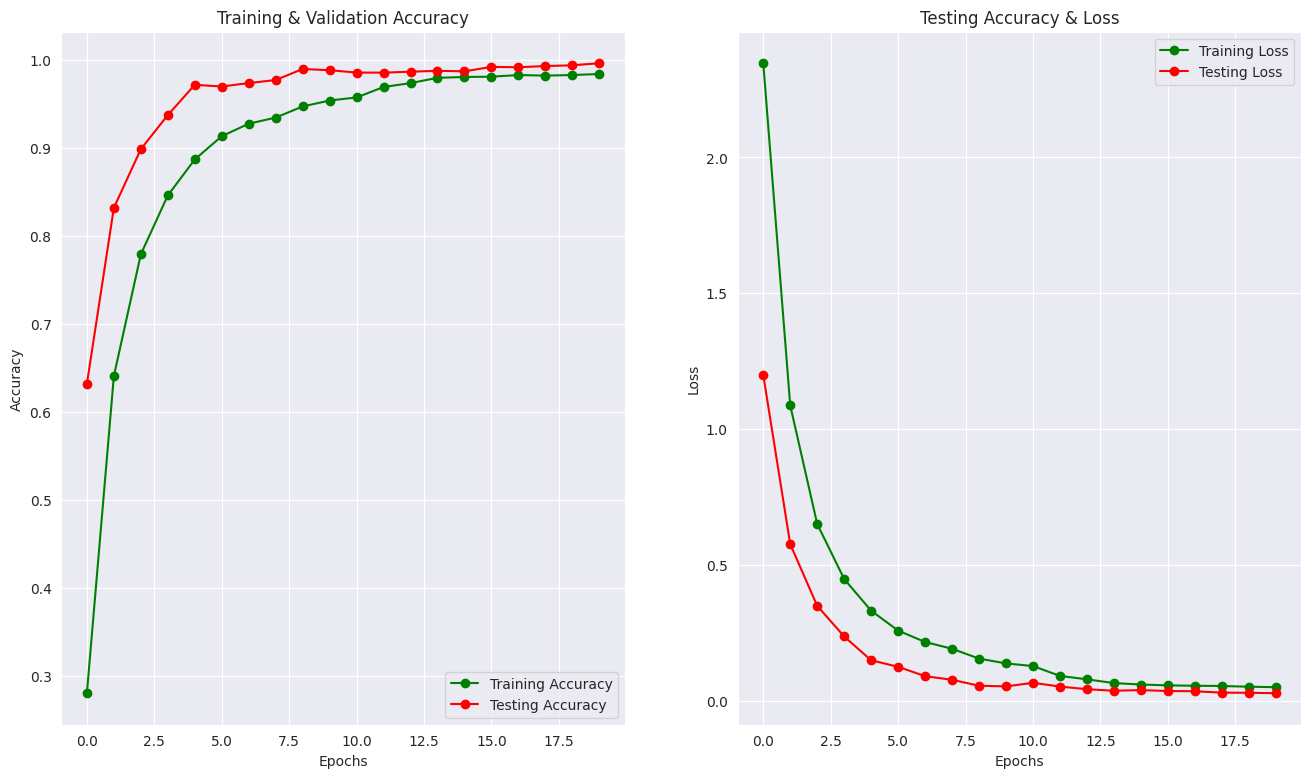

In [47]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [48]:
preds = model.predict(x_test)
predictions = np.argmax(preds, axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step


array([ 6,  5, 10,  0,  3])

In [49]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      0.99      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      0.95      0.97       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       0.99      1.00      0.99       144
    Class 18       0.93    

<Axes: >

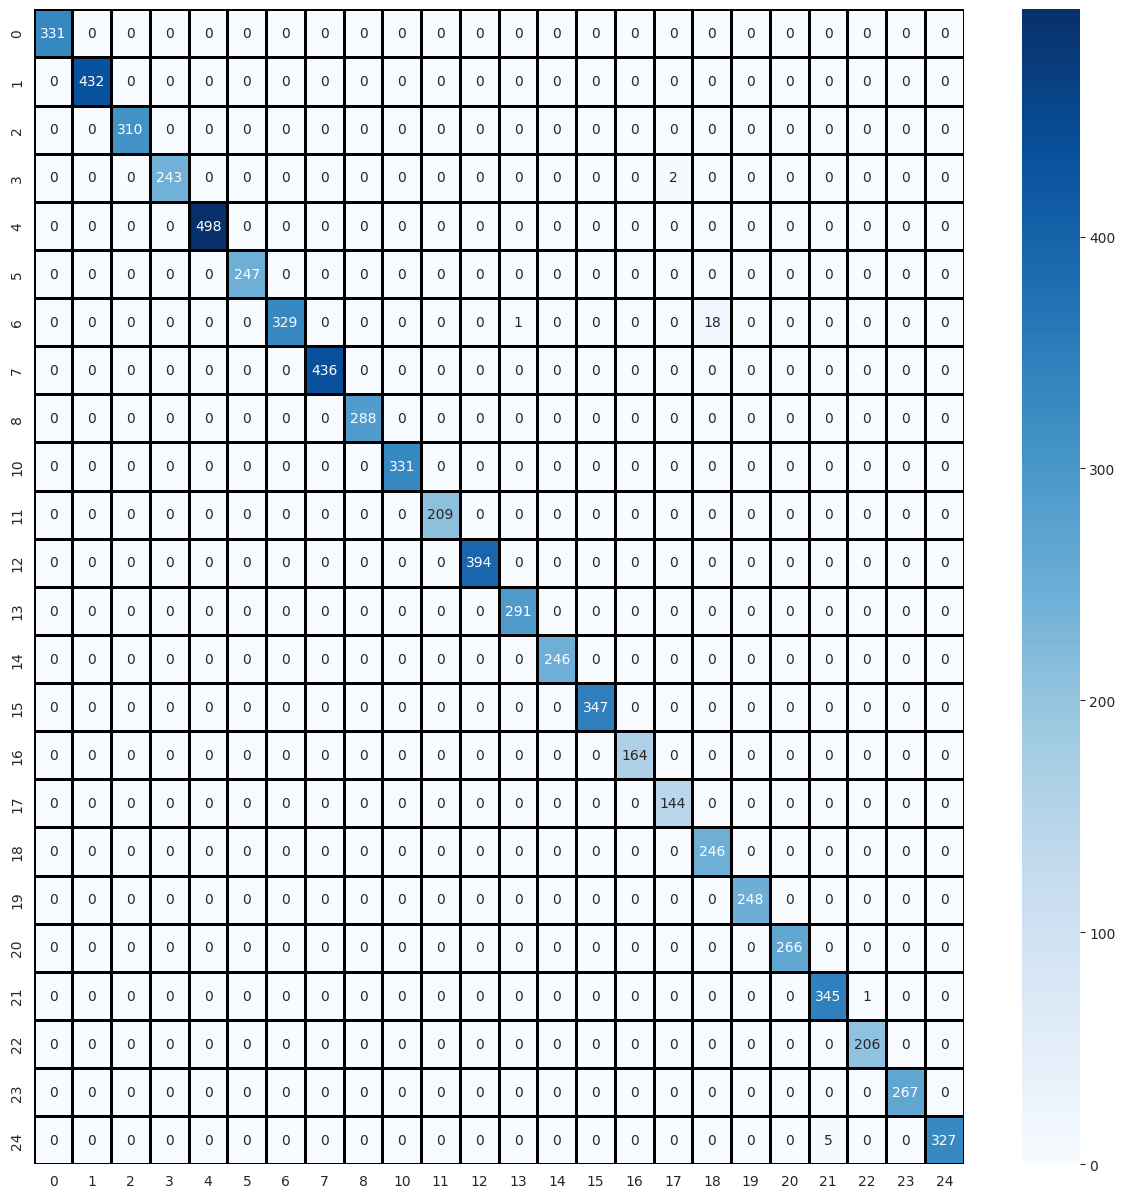

In [50]:
cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [51]:
print(np.array(predictions).shape)
print(y.shape)

(7172,)
(7172,)


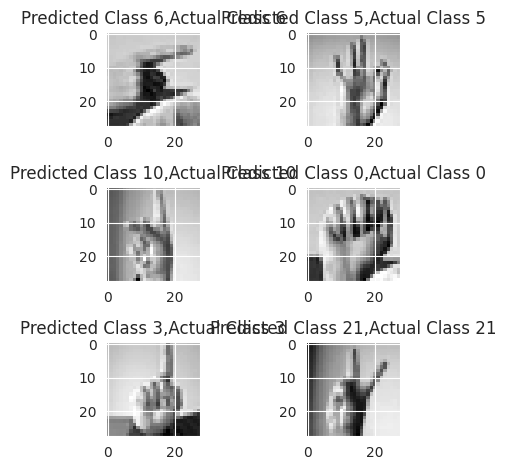

In [52]:
correct = np.nonzero(np.array(predictions) == np.array(y))[0]
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [54]:
model.save('MyAmericanSignLanguageMNIST_model.h5')

In [58]:
import tensorflow.compat.v1 as tf
# x_test_flat=tf.cast(tf.squeeze(x_test, axis=-1), tf.float32) / 255.0
x_test_flat=tf.cast(x_test, tf.float32)# / 255.0
print(x_test_flat.shape)
xtest_ds = tf.data.Dataset.from_tensor_slices((x_test_flat)).batch(1)

(7172, 28, 28, 1)


In [59]:
print(xtest_ds)
def representative_data_gen():
    for input_value in xtest_ds.take(100):
        yield [input_value]

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [60]:
# xtest_rd = test_df.values
def representative_dataset():
    xtest_rd = test_df.values
    for i in range(250):
        nxt = (xtest_rd[i])
        nxt = nxt.reshape(1,28,28,1)
        nxt = np.array(nxt)
        nxt = ((nxt/127.5)-1.0).astype(np.float32)
        yield([nxt])

In [62]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.representative_dataset = representative_dataset#representative_dataset_gen

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

#Implement optimization strategy for smaller model sizes
# converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size

# converter.representative_dataset = representative_data_gen

# tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

Saved artifact at '/tmp/tmpso2mjuk5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_67')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  136690992786192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690953883280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690953895376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926688528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926684880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926684112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926687376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926683920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926682192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136690926683728: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [63]:
open("MyAmericanSignLanguageMNIST_model.tflite", "wb").write(tflite_model)

157616

In [ ]:
## xxd -i ASL_1_lite.tflite > ASL_1.cc

In [65]:
tflite_model_path = "MyAmericanSignLanguageMNIST_model.tflite"

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']
print(input_shape)
print(output_shape)

[ 1 28 28  1]
[ 1 24]


In [66]:
nin = 600
nstrt = 1500
interpreter.resize_tensor_input(input_details[0]['index'], (nin, 28, 28,1))
interpreter.resize_tensor_input(output_details[0]['index'], (nin, 24))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [600  28  28   1]
Input Type: <class 'numpy.int8'>
Output Shape: [600  24]
Output Type: <class 'numpy.int8'>


In [67]:
# test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin),:,:,:], dtype=np.float32)
test_imgs_numpy = np.array(x_test[nstrt:(nstrt+nin),:,:,:]*127.5, dtype=np.int8)
test_imgs_numpy.shape

from time import time
t1 = time()
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print((time()-t1)/nin)
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

0.0005126206080118815
Prediction results shape: (600, 24)


In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(prediction_classes, np.argmax(y_test[nstrt:(nstrt+nin),:],axis=1))

print('Test accuracy TFLITE model :', acc)

Test accuracy TFLITE model : 0.995


### List_TFLite_Operations

In [70]:
import tensorflow as tf

# Replace this with your .tflite file path
tflite_model_path = "MyAmericanSignLanguageMNIST_model.tflite"

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get model details
details = interpreter.get_tensor_details()

# Get operation details
model = interpreter._get_ops_details()

# Print all operation types in the model
print("=== TFLite Operations Used ===")
unique_ops = set()
for i, op in enumerate(model):
    print(f"{i+1}. {op['op_name']}")
    unique_ops.add(op['op_name'])

print("\nUnique operations:", unique_ops)
print(f"Total unique op types: {len(unique_ops)}")


=== TFLite Operations Used ===
1. CONV_2D
2. MAX_POOL_2D
3. CONV_2D
4. MAX_POOL_2D
5. CONV_2D
6. MAX_POOL_2D
7. RESHAPE
8. FULLY_CONNECTED
9. FULLY_CONNECTED
10. SOFTMAX
11. DELEGATE

Unique operations: {'DELEGATE', 'CONV_2D', 'FULLY_CONNECTED', 'SOFTMAX', 'RESHAPE', 'MAX_POOL_2D'}
Total unique op types: 6


### Convert some hex value into an array for C programming

In [71]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

### Write TFLite model to a C source (or header) file

In [73]:
c_model_name = 'MyAmericanSignLanguageMNIST_model'
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))